In [1]:
!nvidia-smi


Wed Feb 17 14:26:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 35%   29C    P8    20W / 260W |    300MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from tensorflow.keras.layers import *
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime
import pandas as pd
import requests

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras import layers

#data = pd.read_csv('bitcoin.csv')
data = pd.read_csv('bitcoin2000.csv')

In [9]:
data.set_index(['timeUTC'],inplace=True)
#data = data['item_cnt_day'].resample('D').sum()
df=pd.DataFrame(data)

In [10]:
from sklearn.preprocessing import MinMaxScaler
values = data[['close']].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
ts = scaler.fit_transform(values)

In [11]:
timestep = 6

X= []
Y=[]

raw_data=ts

for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 8000
Xtrain = X[:k,:,:]  
Ytrain = Y[:k,:1]   

In [12]:
Xtest = X[k:,:,:]  
Ytest= Y[k:,:1]  

In [31]:
timestep=6
n_features=1

In [49]:
class bahdanau(Layer):
    def __init__(self,units):
        super(bahdanau,self).__init__()
        self.w1 = Dense(units)
        self.w2 = Dense(units)
        self.v = Dense(1)
    def call(self, query, values):
        '''
        query : batch_size, lstm_features
        values(==key) : batch_size, max_length, lstm_features
        '''
        query = tf.expand_dims(query,axis=1) # batch,1,lstm_features
        score = tf.nn.tanh(self.w1(values) + self.w2(query)) # batch(128), max_length(500), units(128)
        score = self.v(score) # batch,max_length,1

        attention_weights = tf.nn.softmax(score) # batch, max_len, 1 -> sequence에서 각 단어가 가지는 중요도!

        attention_value = attention_weights * values # batch, max_len, lstm_features
        # axis=1 -> 각 단어별 특징 값을 더한다는 뜻! -> 문장 하나당 1개의 감정분석을 낼 수 있다.
        attention_value = tf.reduce_sum(attention_value, axis=1)
        return attention_value, attention_weights

class Model(tf.keras.models.Model):
    def __init__(self):
        super(Model,self).__init__()
        #self.embedding = Embedding(num_words, 128, input_length=max_len)
        #self.embedding = Embedding(-1,timestep,n_features)
        self.lstm = LSTM(128, return_sequences=True, return_state = True, input_shape=(6,1)) # 전체 타임 스텝의 hidden state를 받고, cell state도 받겠다.
        self.attention = bahdanau(6)
        self.dropout = Dropout(0.3)
        self.dense1 = Dense(30, activation = 'relu')
        self.dense2 = Dense(1)

    def call(self, x, training=False):
        #embedding = self.embedding(x)# batch, 500, 128
        f_input=Input(shape=(6,1))
        lstm_h, h, c = self.lstm(f_input)# (batch, 500, 128), (batch, 128)
        print(lstm_h)
        print(h)
        print(c)
        
        h = tf.concat([h,c], axis=-1) # batch, 256
        attention_v, attention_w = self.attention(h,lstm_h)
        hidden = self.dropout(attention_v, training = training)
        hidden = self.dense1(hidden)
        output = self.dense2(hidden)
        return output

In [50]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                [(None, 6, 128), (None, 1 66560     
_________________________________________________________________
bahdanau_6 (bahdanau)        multiple                  2323      
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dense_33 (Dense)             multiple                  3870      
_________________________________________________________________
dense_34 (Dense)             multiple                  31        
Total params: 72,784
Trainable params: 72,784
Non-trainable params: 0
_________________________________________________________________


In [45]:
model = Model()
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
hist = model.fit(Xtrain,Ytrain, epochs = 3, verbose = 1)

Tensor("model_15/lstm_6/Identity:0", shape=(None, 6, 128), dtype=float32)
Tensor("model_15/lstm_6/Identity_1:0", shape=(None, 128), dtype=float32)
Tensor("model_15/lstm_6/Identity_2:0", shape=(None, 128), dtype=float32)
Train on 8000 samples
Epoch 1/3
Tensor("model_15/lstm_6/StatefulPartitionedCall:1", shape=(None, 6, 128), dtype=float32)
Tensor("model_15/lstm_6/StatefulPartitionedCall:2", shape=(None, 128), dtype=float32)
Tensor("model_15/lstm_6/StatefulPartitionedCall:3", shape=(None, 128), dtype=float32)
Tensor("model_15/lstm_6/StatefulPartitionedCall:1", shape=(None, 6, 128), dtype=float32)
Tensor("model_15/lstm_6/StatefulPartitionedCall:2", shape=(None, 128), dtype=float32)
Tensor("model_15/lstm_6/StatefulPartitionedCall:3", shape=(None, 128), dtype=float32)
  32/8000 [..............................] - ETA: 4:38

InvalidArgumentError:  You must feed a value for placeholder tensor 'model_15/input_1' with dtype float and shape [?,6,1]
	 [[node model_15/input_1 (defined at /home/hj19/anaconda3/envs/spoof/lib/python3.5/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_14820]

Function call stack:
distributed_function


In [52]:
import tensorflow.keras.backend as K
import numpy as np


def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print('shape为',layer_activations.shape)
            print(layer_activations)
    return activations


def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y


def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network    should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y


def get_data_recurrent2(n, time_steps, input_dim, attention_dim=5):
    """
    Suppose input_dim = 10  time_steps = 6
    formed one  x 6 x 10 The data of each step 6 dimension is the same as y
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:,:,attention_dim] =  np.tile(y[:], (1, time_steps))


    return x,y

In [201]:
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate ,Conv1D,Dropout,Bidirectional,Multiply
from tensorflow.keras.models import Model

#from attention_utils import get_activations
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import *
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import *

import  pandas as pd
import  numpy as np

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    #a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# Another way of writing the attention mechanism is suitable for the use of the above error source:https://blog.csdn.net/uhauha2929/article/details/80733255
def attention_3d_block2(inputs, single_attention_vector=False):
    # If the upper layer is LSTM, you need return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # Multiplied by the attention weight, but there is no summation, it seems to have little effect
    # If you classify tasks, you can do Flatten expansion
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul



def create_dataset(dataset, look_back):
    '''
    Processing the data
    '''
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y

# Multidimensional normalization returns data and maximum and minimum values
def NormalizeMult(data):
    #normalize Used for denormalization
    data = np.array(data)
    normalize = np.arange(2*data.shape[1],dtype='float64')

    normalize = normalize.reshape(data.shape[1],2)
    print(normalize.shape)
    for i in range(0,data.shape[1]):
        #Column i
        list = data[:,i]
        listlow,listhigh =  np.percentile(list, [0, 100])
        # print(i)
        normalize[i,0] = listlow
        normalize[i,1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            #Row j
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    #np.save("./normalize.npy",normalize)
    return  data,normalize

# Multidimensional denormalization
def FNormalizeMult(data,normalize):
    data = np.array(data)
    for i in  range(0,data.shape[1]):
        listlow =  normalize[i,0]
        listhigh = normalize[i,1]
        delta = listhigh - listlow
        if delta != 0:
            #Row j
            for j in range(0,data.shape[0]):
                data[j,i]  =  data[j,i]*delta + listlow

    return data


def attention_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))

    #x=layers.Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(6, 1))(inputs)
    #x=layers.Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(6, 1))(x)
    #x=layers.Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    #x=layers.Dense(100)
    #x = Conv1D(filters = 128, kernel_size = 3, activation = 'relu')(inputs)  #, padding = 'same'
    #x = Dropout(0.3)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #For GPU you can use CuDNNLSTM
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(inputs)
    #lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)

    #output = Dense(1, activation='sigmoid')(attention_mul)
    
    output = Dense(1, activation='linear')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [104]:
data=pd.read_csv("bitcoin2000.csv")
data.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timeUTC
0,1576144800,7219.93,7149.15,7170.18,1536.79,11041994.81,7166.14,direct,NaN,2019-12-12 19:00:00
1,1576148400,7208.36,7166.03,7166.14,785.11,5654607.43,7199.79,direct,NaN,2019-12-12 20:00:00
2,1576152000,7222.43,7194.87,7199.79,672.46,4855213.22,7199.97,direct,NaN,2019-12-12 21:00:00
3,1576155600,7211.80,7187.29,7199.97,807.61,5821087.81,7201.38,direct,NaN,2019-12-12 22:00:00
4,1576159200,7229.22,7152.84,7201.38,1606.06,11537799.57,7173.50,direct,NaN,2019-12-12 23:00:00


In [105]:

data = data.drop(['time','conversionType','conversionSymbol','high','open','volumefrom','volumeto'], axis = 1)
print(data.columns)
print(data.shape)

Index(['low', 'close', 'timeUTC'], dtype='object')
(10005, 3)


In [106]:
data.set_index(['timeUTC'],inplace=True)


In [107]:
data

,low,close
timeUTC,,
2019-12-12 19:00:00,7149.15,7166.14
2019-12-12 20:00:00,7166.03,7199.79
2019-12-12 21:00:00,7194.87,7199.97
2019-12-12 22:00:00,7187.29,7201.38
2019-12-12 23:00:00,7152.84,7173.50
...,...,...
2021-02-01 11:00:00,33257.39,33675.45
2021-02-01 12:00:00,33505.50,33590.20
2021-02-01 13:00:00,33404.87,33576.82


In [120]:
pollution_data = data[:,0].reshape(len(data),1)
pollution_data

array([[0.08642125],
       [0.08687709],
       [0.08765591],
       ...,
       [0.79544911],
       [0.79715041],
       [0.80448921]])

In [202]:
INPUT_DIMS = 2
TIME_STEPS = 6
lstm_units = 100

#Normalized
data,normalize = NormalizeMult(data)
pollution_data = data[:,1].reshape(len(data),1)

train_X, _ = create_dataset(data,TIME_STEPS)
_ , train_Y = create_dataset(pollution_data,TIME_STEPS)

print(train_X.shape,train_Y.shape)

m = attention_model()
m.summary()
m.compile(optimizer='adam', loss='mse')
m.fit([train_X], train_Y, epochs=10, batch_size=64, validation_split=0.1)
#m.save("./model.h5")
#np.save("normalize.npy",normalize)

(2, 2)
(9998, 6, 2) (9998, 1)
Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 6, 2)]       0                                            
__________________________________________________________________________________________________
bidirectional_21 (Bidirectional (None, 6, 200)       82400       input_24[0][0]                   
__________________________________________________________________________________________________
dense_83 (Dense)                (None, 6, 200)       40200       bidirectional_21[0][0]           
__________________________________________________________________________________________________
attention_vec (Permute)         (None, 6, 200)       0           dense_83[0][0]                   
_____________________________________________________________

In [110]:
df=data.copy()

In [111]:
from sklearn.model_selection import train_test_split

train_size = int(len(df)*0.8)
train = df.iloc[:train_size,:]
test = df.iloc[train_size:,:]
#train, test = train_test_split(df, test_size=0.1)
print("len(train):",len(train))
print("len(test):",len(test))

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [112]:

import tensorflow.keras.backend as K
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [122]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_path = './model.h5'
# TRAIN
INPUT_DIMS = 6
TIME_STEPS = 20
lstm_units = 64

#Normalized
train,normalize = NormalizeMult(train)
pollution_data = train[:,0].reshape(len(train),1)

train_X, _ = create_dataset(train,TIME_STEPS)
_ , train_Y = create_dataset(pollution_data,TIME_STEPS)
print(train_X.shape,train_Y.shape)

m = attention_model()
m.summary()
#m.compile(optimizer='adam', loss='mse')
m.compile(loss='mse', optimizer='adam',metrics=['mae',r2_keras])

# fit the network
history =  m.fit([train_X], train_Y, epochs=10, batch_size=64, validation_split=0.1)
#history = m.fit([train_X], train_Y, epochs=10, batch_size=64, validation_split=0.05, verbose=2,
#          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
#                       ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
#          )

(6, 2)
(7983, 20, 6) (7983, 1)
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 20, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 18, 256)      4864        input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 16, 256)      196864      conv1d_19[0][0]                  
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 16, 128)      32896       conv1d_20[0][0]                  
____________________________________________________________

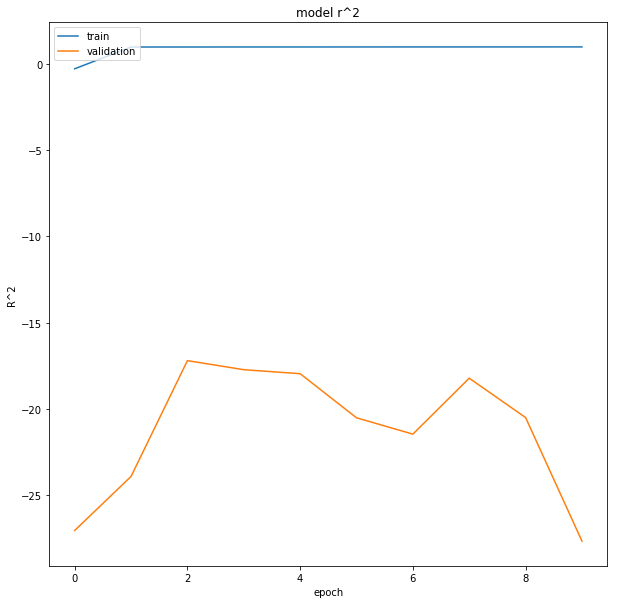

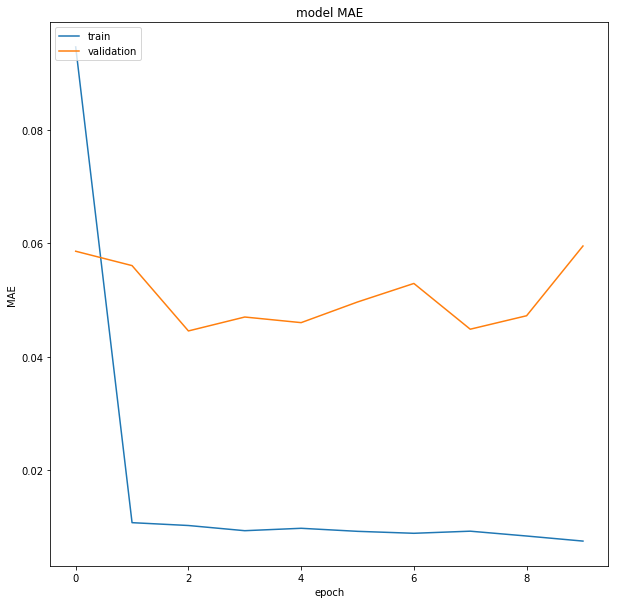

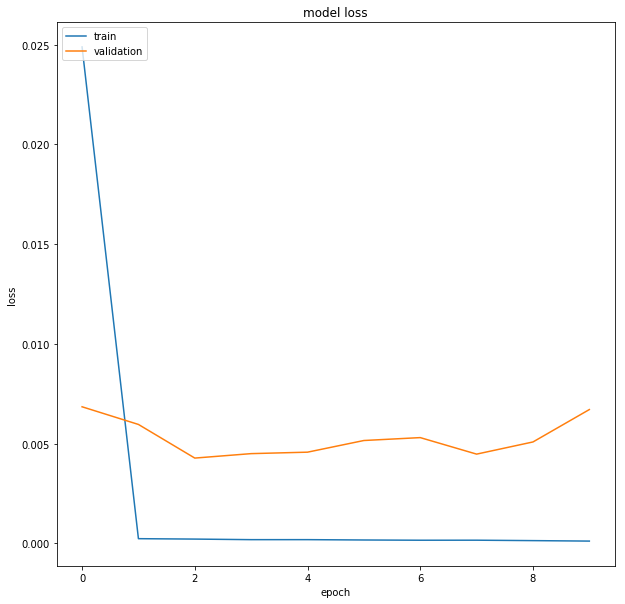

In [114]:
import matplotlib.pyplot as plt

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [115]:

# TEST
test,normalize = NormalizeMult(test)
pollution_test = test[:,0].reshape(len(test),1)

test_X, _ = create_dataset(test,TIME_STEPS)
_ , test_Y = create_dataset(pollution_test,TIME_STEPS)
print(test_X.shape,test_Y.shape)

(6, 2)
(1980, 20, 6) (1980, 1)


In [116]:
scores_test = m.evaluate([test_X], test_Y, verbose=2)


1980/1 - 0s - loss: 0.0021 - mae: 0.0421 - r2_keras: -1.1841e+01


In [117]:
scores_test


[0.0032740938519550994, 0.042144965, -11.840757]

In [118]:
results = m.predict([test_X])


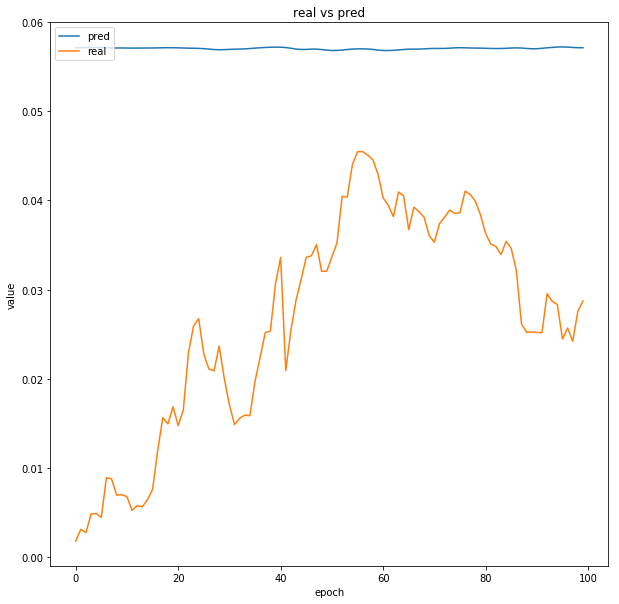

In [119]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(results[:100])
plt.plot(test_Y[:100])
plt.title('real vs pred')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['pred', 'real'], loc='upper left')
plt.show()

In [138]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import Callback


In [139]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [141]:
class ResetCallback(Callback):
    def __init__(self):
        self.counter = 0

    def on_batch_begin(self, batch, logs={}):
        if stateful:
            if self.counter % time_steps == 0:
                self.model.reset_states()
        self.counter += 1

In [154]:
batch_size=1
time_steps=6
features = 1
column = 'A'
stateful = True
single = False

def attention_lstm(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    print(inputs.shape)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, time_steps))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(time_steps, activation='softmax')(a)
    if single:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    attention_m = multiply([inputs, a_probs])
    return attention_m

#network
input = Input(batch_shape=(batch_size,6,1), name='input', dtype='float32')
lstm_layer1 = Bidirectional(LSTM(units=100, return_sequences=True, return_state=False, stateful=stateful)) (input)
attention_m = attention_lstm(lstm_layer1)
attention_m = Flatten()(attention_m)  
#output=Dense(100)(attention_m)
output = Dense(units=1) (attention_m)

#optimizer
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
optimizer='adam'
model = Model(inputs = input, outputs = output)
model.compile(optimizer= optimizer, loss='mean_squared_error', metrics=[rmse])
history = model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=10, verbose=2, validation_data=(Xtest,Ytest), shuffle=not(stateful), callbacks=[ResetCallback()])

(1, 6, 200)
Train on 8000 samples, validate on 1999 samples
Epoch 1/10
8000/8000 - 26s - loss: 1.8070e-05 - rmse: 0.0026 - val_loss: 0.1080 - val_rmse: 0.2618
Epoch 2/10
8000/8000 - 24s - loss: 4.0017e-05 - rmse: 0.0023 - val_loss: 0.1063 - val_rmse: 0.2601
Epoch 3/10
8000/8000 - 24s - loss: 4.5494e-05 - rmse: 0.0026 - val_loss: 0.1127 - val_rmse: 0.2677
Epoch 4/10
8000/8000 - 24s - loss: 4.3619e-05 - rmse: 0.0022 - val_loss: 0.1193 - val_rmse: 0.2756
Epoch 5/10
8000/8000 - 24s - loss: 3.8843e-05 - rmse: 0.0020 - val_loss: 0.1079 - val_rmse: 0.2636
Epoch 6/10
8000/8000 - 24s - loss: 3.4816e-05 - rmse: 0.0021 - val_loss: 0.1422 - val_rmse: 0.3034
Epoch 7/10
8000/8000 - 24s - loss: 4.1722e-05 - rmse: 0.0022 - val_loss: 0.1324 - val_rmse: 0.2902
Epoch 8/10
8000/8000 - 24s - loss: 4.0397e-05 - rmse: 0.0019 - val_loss: 0.1272 - val_rmse: 0.2839
Epoch 9/10
8000/8000 - 24s - loss: 4.0774e-05 - rmse: 0.0017 - val_loss: 0.1001 - val_rmse: 0.2532
Epoch 10/10
8000/8000 - 24s - loss: 4.6961e-05 - 

In [144]:
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(1, 6, 1)]          0                                            
__________________________________________________________________________________________________
bidirectional_14 (Bidirectional (1, 6, 40)           3520        input[0][0]                      
__________________________________________________________________________________________________
permute_5 (Permute)             (1, 40, 6)           0           bidirectional_14[0][0]           
__________________________________________________________________________________________________
reshape_5 (Reshape)             (1, 40, 6)           0           permute_5[0][0]                  
___________________________________________________________________________________________

dict_keys(['val_loss', 'loss', 'rmse', 'val_rmse'])


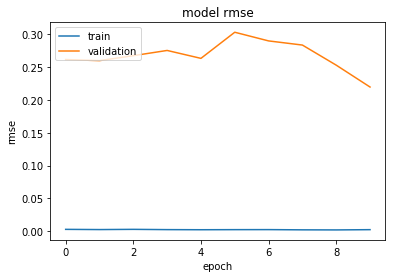

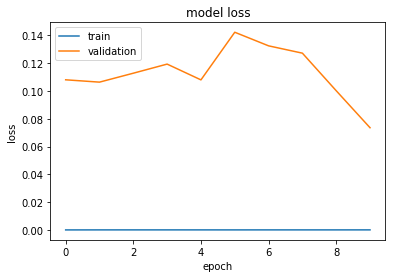

In [155]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [157]:
# generate predictions for training
trainPredict = model.predict(Xtrain, batch_size)
model.reset_states()
testPredict = model.predict(Xtest, batch_size)


trainPred = pd.Series(trainPredict[:,0])
trainAct = pd.Series(Ytrain)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(train)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_steps:len(trainPredict)+time_steps, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(series)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(time_steps*2)+1:len(series)-1, :] = testPredict
# plot baseline and predictions
plt.plot(series)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Exception: Data must be 1-dimensional

In [193]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(12)

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Masking

from tensorflow.keras import optimizers
from tensorflow.keras import models
from attention import AttentionLayer

In [195]:
def build_vanilla_model():
    model_in = Input(shape=(6, 1), name='sequence-in')
    vectors  = LSTM(units=4, name='lstm')(model_in)
    output   = Dense(units=1, activation='linear')(vectors)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()

    model.compile(optimizers.Adam(1e-2), 'mse', metrics=['mse'])
    return model


def build_attention_model():
    model_in = Input(shape=(None, 1), name='sequence-in')
    masked   = Masking(name='mask')(model_in)
    vectors  = LSTM(units=4, name='lstm', return_sequences=True)(masked)

    descr    = AttentionLayer(name='attention')(vectors)
    output   = Dense(units=1, activation='linear')(descr)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()

    model.compile(optimizers.Adam(5e-2), 'mse', metrics=['mse'])
    return model

In [163]:
vanilla_model = build_vanilla_model()
vanilla_model.fit(Xtrain, Ytrain, batch_size=32, epochs=10)

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     [(None, 6, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Train on 8000 samples
Epoch 1/10
8000/8000 [==============================] - 2s 288us/sample - loss: 0.0013 - mse: 0.0013
Epoch 2/10
8000/8000 [==============================] - 1s 68us/sample - loss: 7.3651e-06 - mse: 7.3651e-06
Epoch 3/10
8000/8000 [==============================] - 1s 67us/sample - loss: 6.7546e-06 - mse: 6.7546e-06
Epoch 4/10
8000/8000 [=============================

In [196]:

attention_model = build_attention_model()
attention_model.predict(Xtrain).shape
attention_model.fit(Xtrain, Ytrain, batch_size=32, epochs=10)

TypeError: add_weight() got multiple values for argument 'name'